# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd "/content/drive//My Drive/paris"

/content/drive/My Drive/paris


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
from tqdm import tqdm
import os
import time
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:

!pip install geopandas
!pip install contextily
!pip install git+https://github.com/tensorflow/docs

clear_output()

In [5]:
import statsmodels.api as sm

import statsmodels.formula.api as smf
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily
from shapely.geometry import Point, Polygon


In [6]:
# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot

import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds

Using TensorFlow backend.


In [7]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Load Input Data

In [8]:
data = pd.read_csv('goldData.csv')

In [9]:
data[' SPEED'] = data[' SPEED'].str.split('km/h',expand=True).drop(columns = [1]).astype(np.float32)
data.columns

Index(['Unnamed: 0', 'INDEX', ' RCR', ' UTC DATE', ' UTC TIME', ' LOCAL DATE',
       ' LOCAL TIME', ' MS', ' VALID', ' LATITUDE', ' N/S', ' LONGITUDE',
       ' E/W', ' HEIGHT', ' SPEED', ' HEADING', ' PDOP', ' HDOP', ' VDOP',
       ' NSAT(USED/VIEW)', 'file_name', 'unique_id', 'MVPA', 'age', 'Sexe',
       'variable', 'value', 'capacity', 'tree'],
      dtype='object')

In [10]:
features = data[[' LATITUDE', ' LONGITUDE','age', 'Sexe',
        'value', 'capacity', 'tree' ]].astype(np.float32)
target = data[[' SPEED']].astype(np.float32)
n_features = features.shape[1]
n_targets = target.shape[1]

rawData = tf.data.Dataset.from_tensor_slices((features, target))

In [11]:
for i in rawData.take(5):
  print(i)


(<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([4.8871e+01, 2.4420e+00, 5.6760e+01, 1.0000e+00, 3.8410e+03,
       0.0000e+00, 0.0000e+00], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.501], dtype=float32)>)
(<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([4.8871e+01, 2.4420e+00, 5.6760e+01, 1.0000e+00, 3.8410e+03,
       0.0000e+00, 0.0000e+00], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8], dtype=float32)>)
(<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([4.8871e+01, 2.4420e+00, 5.6760e+01, 1.0000e+00, 3.8410e+03,
       0.0000e+00, 0.0000e+00], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.103], dtype=float32)>)
(<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([4.8871e+01, 2.4420e+00, 5.6760e+01, 1.0000e+00, 3.8410e+03,
       0.0000e+00, 0.0000e+00], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.631], dtype=float32)>)
(<tf.Tensor: shape=(7,), dtype=float32, nu

In [12]:
n_timesteps = 10
sequences = rawData.batch(n_timesteps, drop_remainder=True)

In [13]:
# Batch size
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 10, 7), (64, 10, 1)), types: (tf.float32, tf.float32)>

In [14]:
# test_dataset = dataset.take(1000)
# val_dataset = dataset.skip(1000)
# train_dataset = dataset.skip(1000)
# train_dataset = dataset.take(2000)

In [15]:
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(test_size)
# test_dataset = test_dataset.take(test_size)

In [45]:
train_stats = features.describe()
train_stats = train_stats.transpose()
train_stats

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(features)
normed_target = (target - target.mean())/target.std()


train = normed_train_data.to_numpy()
train = train[1000:-9,:].reshape((-1,10,7))
label = normed_target.to_numpy()
label = label[1000:-9,:].reshape((-1,10,1))

test = train[:1000,:].reshape((-1,10,7))
test_label = label[:1000,:].reshape((-1,10,1))

In [40]:
train[:5,:]

array([[[-1.00714607,  0.83046678,  0.56050777, -0.60591252,
          1.44348654, -0.34655551,  0.51012619],
        [-1.00714607,  0.83046678,  0.56050777, -0.60591252,
          1.44348654, -0.34655551,  0.51012619],
        [-1.00714607,  0.83046678,  0.56050777, -0.60591252,
          1.44348654, -0.34655551,  0.51012619],
        [-1.00714607,  0.83046678,  0.56050777, -0.60591252,
          1.44348654, -0.34655551,  0.51012619],
        [-1.00714607,  0.83046678,  0.56050777, -0.60591252,
          1.44348654, -0.34655551,  0.51012619],
        [-1.00714607,  0.83046678,  0.56050777, -0.60591252,
          1.44348654, -0.34655551,  0.51012619],
        [-1.00714607,  0.83046678,  0.56050777, -0.60591252,
          1.44348654, -0.34655551,  0.51012619],
        [-1.00714607,  0.83046678,  0.56050777, -0.60591252,
          1.44348654, -0.34655551,  0.51012619],
        [-1.00714607,  0.83046678,  0.56050777, -0.60591252,
          1.44348654, -0.34655551,  0.51012619],
        [-

In [ ]:
sns.pairplot(features, diag_kind="kde")

In [ ]:
sns.pairplot(normed_train_data, diag_kind="kde")

In [25]:
target.shape

(8046439, 1)

# Model

In [48]:
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features), return_sequences=True, recurrent_initializer='glorot_uniform'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_targets))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])

In [49]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 10, 1) # (batch_size, sequence_length, vocab_size)


In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 100)           43200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 10, 100)           10100     
_________________________________________________________________
dense_8 (Dense)              (None, 10, 1)             101       
Total params: 53,401
Trainable params: 53,401
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(x = train,y = label, batch_size = 512,
  epochs=20, validation_split = 0.02, verbose=2, callbacks=[tfdocs.modeling.EpochDots()])

Train on 788452 samples, validate on 16091 samples
Epoch 1/20
 - 158s - loss: 0.9751 - mae: 0.3549 - mse: 0.9751 - val_loss: 1.7503 - val_mae: 0.4289 - val_mse: 1.7503

Epoch: 0, loss:0.9751,  mae:0.3549,  mse:0.9751,  val_loss:1.7503,  val_mae:0.4289,  val_mse:1.7503,  
.Epoch 2/20
 - 160s - loss: 0.9551 - mae: 0.3486 - mse: 0.9551 - val_loss: 1.7068 - val_mae: 0.4189 - val_mse: 1.7068
.Epoch 3/20
 - 160s - loss: 0.9363 - mae: 0.3444 - mse: 0.9363 - val_loss: 1.7033 - val_mae: 0.4091 - val_mse: 1.7033
.Epoch 4/20
 - 159s - loss: 0.9242 - mae: 0.3409 - mse: 0.9242 - val_loss: 1.7139 - val_mae: 0.4213 - val_mse: 1.7139
.Epoch 5/20
 - 158s - loss: 0.9168 - mae: 0.3386 - mse: 0.9168 - val_loss: 1.7260 - val_mae: 0.4040 - val_mse: 1.7260
.Epoch 6/20
 - 148s - loss: 0.9057 - mae: 0.3360 - mse: 0.9057 - val_loss: 1.7296 - val_mae: 0.4167 - val_mse: 1.7296
.Epoch 7/20
 - 150s - loss: 0.8930 - mae: 0.3339 - mse: 0.8930 - val_loss: 1.7205 - val_mae: 0.4178 - val_mse: 1.7205
.Epoch 8/20
 - 147s 

In [83]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
15,1.693406,0.413098,1.693406,0.847216,0.325237,0.847216,15
16,2.783831,0.448991,2.783831,0.839830,0.324402,0.839831,16
17,2.394211,0.431864,2.394212,0.825974,0.322511,0.825974,17
18,1.716243,0.401856,1.716243,0.819621,0.321961,0.819621,18
19,2.849796,0.444303,2.849796,0.822354,0.321561,0.822354,19


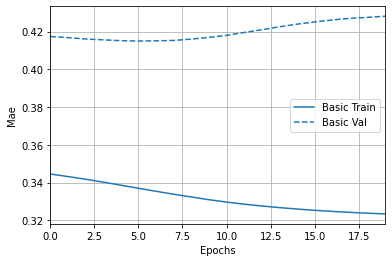

In [88]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.savefig('mae_1.pdf')

In [95]:
loss, mae, mse = model.evaluate(test, test_label, verbose=0)
print(loss, mae)

0.20510627579968424 0.26989009976387024


# Model 2

In [21]:
def build_model(rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(rnn_units, input_shape=(n_timesteps,n_features), return_sequences=True),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(rnn_units, activation='relu'),
    tf.keras.layers.Dense(n_targets, activation='softmax')
  ])
  return model

In [22]:
model = build_model(
  rnn_units=100,
  batch_size=BATCH_SIZE)

In [23]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 10, 1) # (batch_size, sequence_length, vocab_size)


In [24]:
optimizer = tf.keras.optimizers.Adam()

In [25]:
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model(inp)
    loss = tf.reduce_mean(
        tf.keras.losses.mse(
            target, predictions))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

In [26]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [27]:
# Training step
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  # initializing the hidden state at the start of every epoch
  # initally hidden is None
  hidden = model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target)

    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 58.80177688598633
Epoch 1 Batch 100 Loss 6.115139007568359
Epoch 1 Batch 200 Loss 1.5945171117782593
Epoch 1 Batch 300 Loss 3.1388373374938965
Epoch 1 Batch 400 Loss 0.9992639422416687
Epoch 1 Batch 500 Loss 0.8367385864257812
Epoch 1 Batch 600 Loss 31.87209129333496
Epoch 1 Batch 700 Loss 7.139329433441162
Epoch 1 Batch 800 Loss 15.559247016906738
Epoch 1 Batch 900 Loss 1.6260448694229126
Epoch 1 Batch 1000 Loss 6.623732089996338
Epoch 1 Batch 1100 Loss 1.6983531713485718
Epoch 1 Batch 1200 Loss 21.44990348815918
Epoch 1 Batch 1300 Loss 117.8244857788086
Epoch 1 Batch 1400 Loss 1.9643253087997437
Epoch 1 Batch 1500 Loss 34.10836410522461
Epoch 1 Batch 1600 Loss 5.109980583190918
Epoch 1 Batch 1700 Loss 3.1685709953308105
Epoch 1 Batch 1800 Loss 11.834123611450195
Epoch 1 Batch 1900 Loss 28.4960880279541
Epoch 1 Batch 2000 Loss 134.3955535888672
Epoch 1 Batch 2100 Loss 38.15746307373047
Epoch 1 Batch 2200 Loss 54.47621536254883
Epoch 1 Batch 2300 Loss 21.5996131896

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')